In [1]:
data_dir = "C:/Users/leona/Documents/Projects/Full/images"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
batch_size = 32
img_height = 225
img_width = 300

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 2 classes.
Using 8012 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 2 classes.
Using 2003 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 225, 300, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.17450981 0.8333334


In [11]:
num_classes = len(class_names)

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.9),
    layers.RandomZoom(0.6),
  ]
)

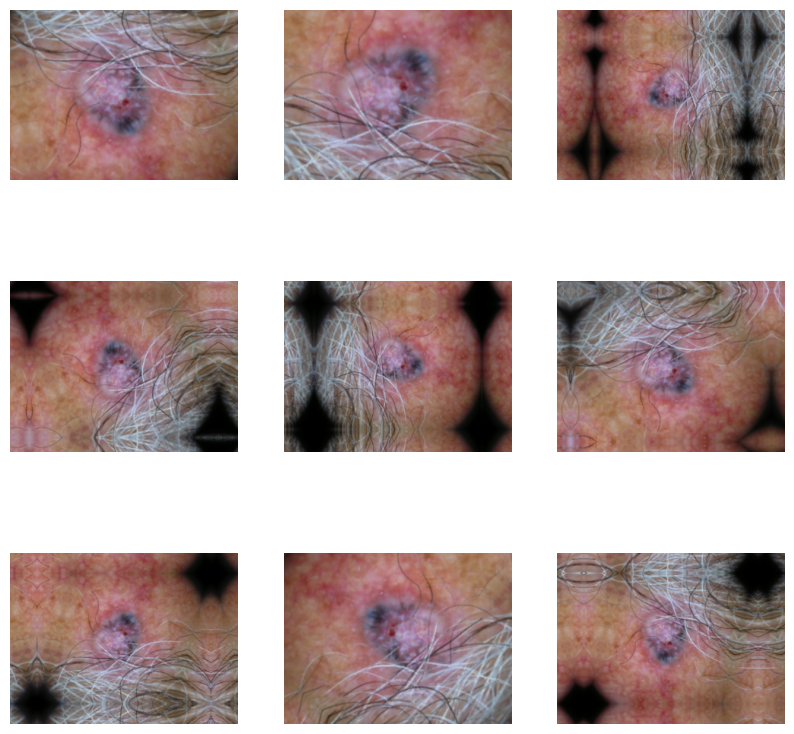

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
251/251 [==============================] - 153s 600ms/step - loss: 0.4620 - accuracy: 0.8360 - val_loss: 0.3903 - val_accuracy: 0.8387
Epoch 2/50
251/251 [==============================] - 151s 602ms/step - loss: 0.4162 - accuracy: 0.8372 - val_loss: 0.4441 - val_accuracy: 0.8387
Epoch 3/50
251/251 [==============================] - 159s 635ms/step - loss: 0.3974 - accuracy: 0.8374 - val_loss: 0.4012 - val_accuracy: 0.8387
Epoch 4/50
251/251 [==============================] - 159s 634ms/step - loss: 0.3929 - accuracy: 0.8372 - val_loss: 0.3809 - val_accuracy: 0.8387
Epoch 5/50
251/251 [==============================] - 155s 618ms/step - loss: 0.3870 - accuracy: 0.8372 - val_loss: 0.3856 - val_accuracy: 0.8387
Epoch 6/50
251/251 [==============================] - 155s 618ms/step - loss: 0.3817 - accuracy: 0.8371 - val_loss: 0.3788 - val_accuracy: 0.8387
Epoch 7/50
251/251 [==============================] - 154s 615ms/step - loss: 0.3747 - accuracy: 0.8375 - val_loss: 0.3731 -

251/251 [==============================] - 150s 596ms/step - loss: 0.3317 - accuracy: 0.8489 - val_loss: 0.3284 - val_accuracy: 0.8447
Epoch 41/50
251/251 [==============================] - 150s 597ms/step - loss: 0.3216 - accuracy: 0.8520 - val_loss: 0.3529 - val_accuracy: 0.8248
Epoch 42/50
251/251 [==============================] - 149s 595ms/step - loss: 0.3280 - accuracy: 0.8451 - val_loss: 0.3256 - val_accuracy: 0.8487
Epoch 43/50
251/251 [==============================] - 150s 596ms/step - loss: 0.3268 - accuracy: 0.8518 - val_loss: 0.3214 - val_accuracy: 0.8427
Epoch 44/50
251/251 [==============================] - 150s 596ms/step - loss: 0.3246 - accuracy: 0.8499 - val_loss: 0.3327 - val_accuracy: 0.8397
Epoch 45/50
251/251 [==============================] - 150s 597ms/step - loss: 0.3293 - accuracy: 0.8441 - val_loss: 0.3300 - val_accuracy: 0.8482
Epoch 46/50
251/251 [==============================] - 149s 595ms/step - loss: 0.3246 - accuracy: 0.8457 - val_loss: 0.3225 - val_

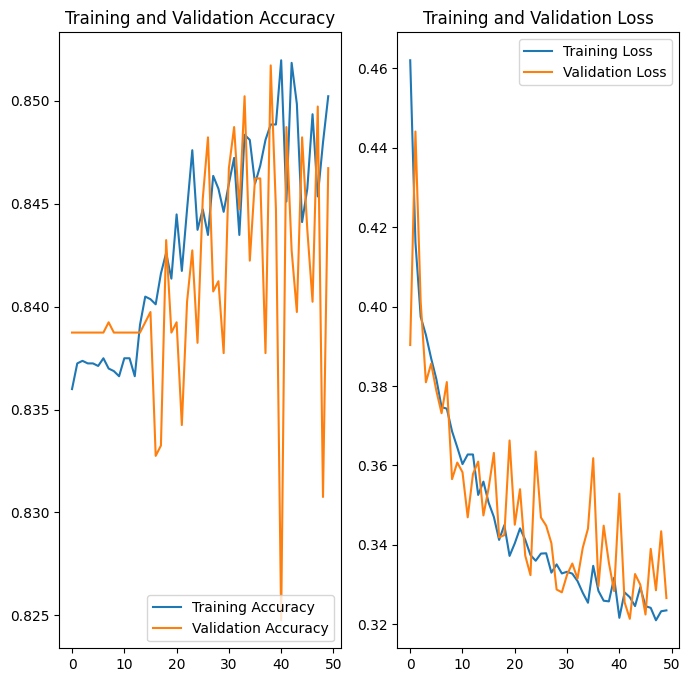

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()